In [1]:
import numpy as np
import os
from keras.models import Model
from keras import backend as K
from keras.regularizers import l1
from keras.utils import plot_model
from keras.datasets import mnist, cifar10
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, Dropout, BatchNormalization
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence
from keras.layers.convolutional import Conv1D, Conv2DTranspose, UpSampling1D, MaxPooling1D
import h5py
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import keras.optimizers as optimizers

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# network parameters
input_shape = (512, 1)
dropout_rate = 0.1
batch_size = 1024
latent_dim = 2

In [4]:
# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')
x = Conv1D(256, 3, strides=2, activation='relu', padding='same')(inputs)
x = Dropout(dropout_rate)(x)
x = Conv1D(128, 3, strides=2, activation='relu', padding='same')(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(96, 3, activation='relu', padding='same')(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(latent_dim)(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
inner_shape = (latent_dim,)
latent_inputs = Input(shape=inner_shape, name='z_sampling')
x = Dense(12288)(latent_inputs)
x = Reshape((128, 96))(x)
x = Conv1D(96, 3, strides=1, activation='relu', padding='same')(x)
x = UpSampling1D()(x)
x = Conv1D(128, 3, strides=1, activation='relu', padding='same')(x)
x = UpSampling1D()(x)
x = Conv1D(160, 3, activation='relu', padding='same')(x)
outputs = Conv1D(1, 1, activation='linear')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 512, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 256)     1024        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 128, 128)     98432       dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [5]:
DATA_DIRECTORY = '/mnt/disks/ecg-bike-tensors-2/2019-09-17/'
a = None
with h5py.File(os.path.join(DATA_DIRECTORY,'1000113.hd5'), 'r') as hd5:
    date = list(hd5['ecg_bike/string/protocol/'].keys())[0]
    a = np.array(hd5[f'ecg_bike/float_array/full/{date}'])

In [6]:
interleaved = np.zeros(len(a) * 3)
interleaved[::3] = a[:,0]
interleaved[1::3] = a[:,1]
interleaved[2::3] = a[:,2]
lead_I = []
for i in range(0, len(interleaved), 3):
    lead_I += list(interleaved[500 * i: 500 * (i + 1)])
a = np.array(lead_I)

In [7]:
print(a.mean(), a.std())
a -= a.mean()
a /= a.std()
print(a.mean(), a.std())

17.64009699769053 49.57611404847737
-4.726011729766948e-18 0.9999999999999997


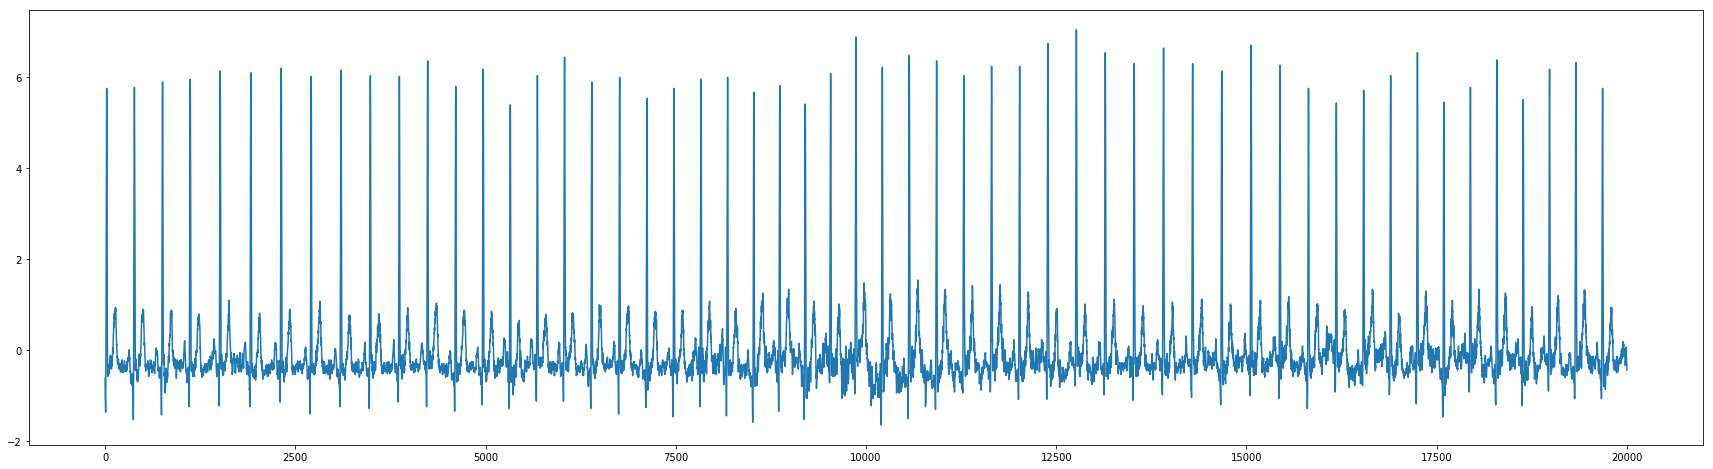

In [8]:
plt.figure(figsize=(30, 8))
plt.plot(a[:20000])

In [9]:
def subset():
    i = np.random.randint(len(a) - 512)
    return a[i: i + 512]

In [10]:
data = np.array([subset() for _ in range(10000)])[..., np.newaxis]

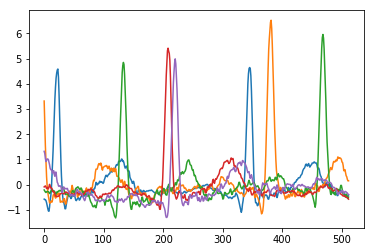

In [11]:
for i in range(5):
    plt.plot(data[i])

In [ ]:
outputs = decoder(encoder(inputs)[2])  # 2 is the sampled z
vae = Model(inputs, outputs, name='vae_cnn')
vae.summary()

# Compute VAE loss
def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(y_true, y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(250 * K.mean(reconstruction_loss) + kl_loss)
    return vae_loss


vae.compile(optimizer=optimizers.Adam(1e-3), loss=vae_loss)
vae.summary()
epochs = 5000
vae.fit(data, data, shuffle=True, batch_size=batch_size, epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 512, 1)            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 161006    
_________________________________________________________________
decoder (Model)              (None, 512, 1)            163361    
Total params: 324,367
Trainable params: 324,367
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 512, 1)            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 161006    
_________________________________________________________________
deco

In [13]:
x_test = np.array([subset() for _ in range(1000)])[..., np.newaxis]

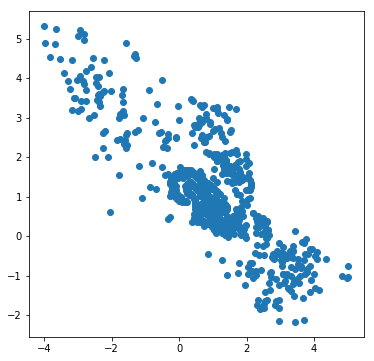

In [14]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1], cmap='jet')
plt.show()

In [15]:
ordered = np.array([a[i: i + 512] for i in range(0, len(a) - 512, 2)])[..., np.newaxis]

In [16]:
x_test_encoded = encoder.predict(ordered, batch_size=batch_size)

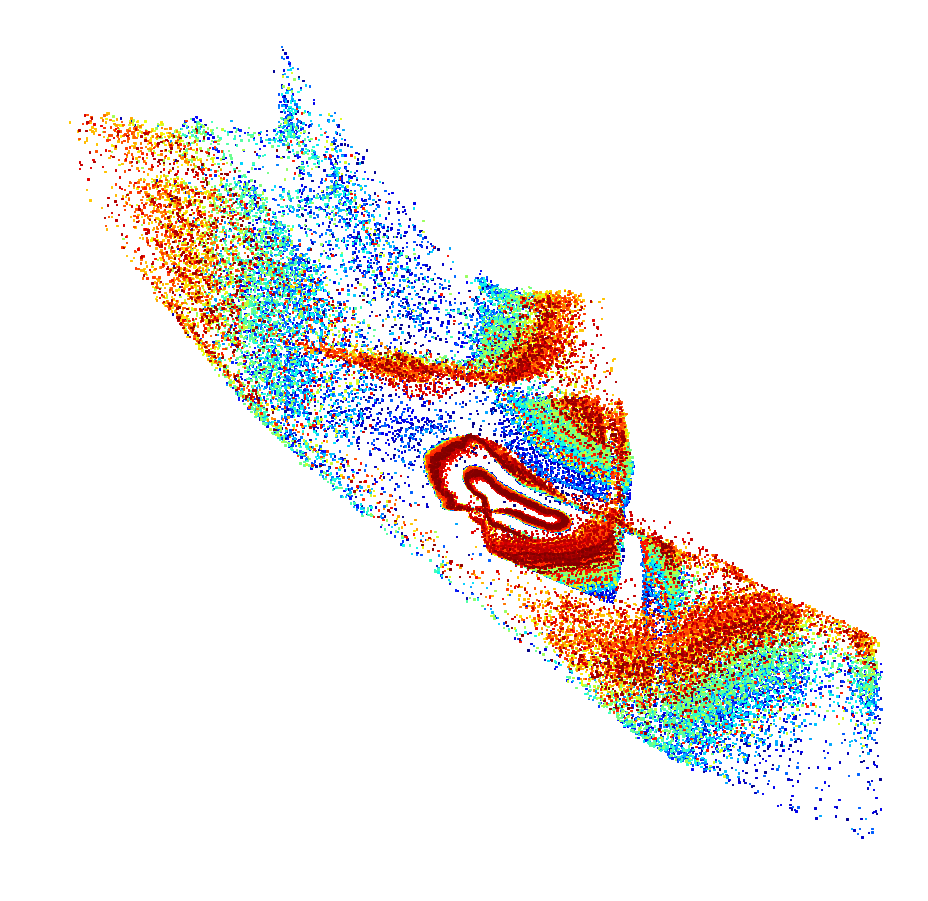

In [21]:
plt.figure(figsize=(16, 16))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=np.arange(len(ordered)) / len(ordered), cmap='jet', marker=',', s=2)
plt.axis('off')
plt.show()

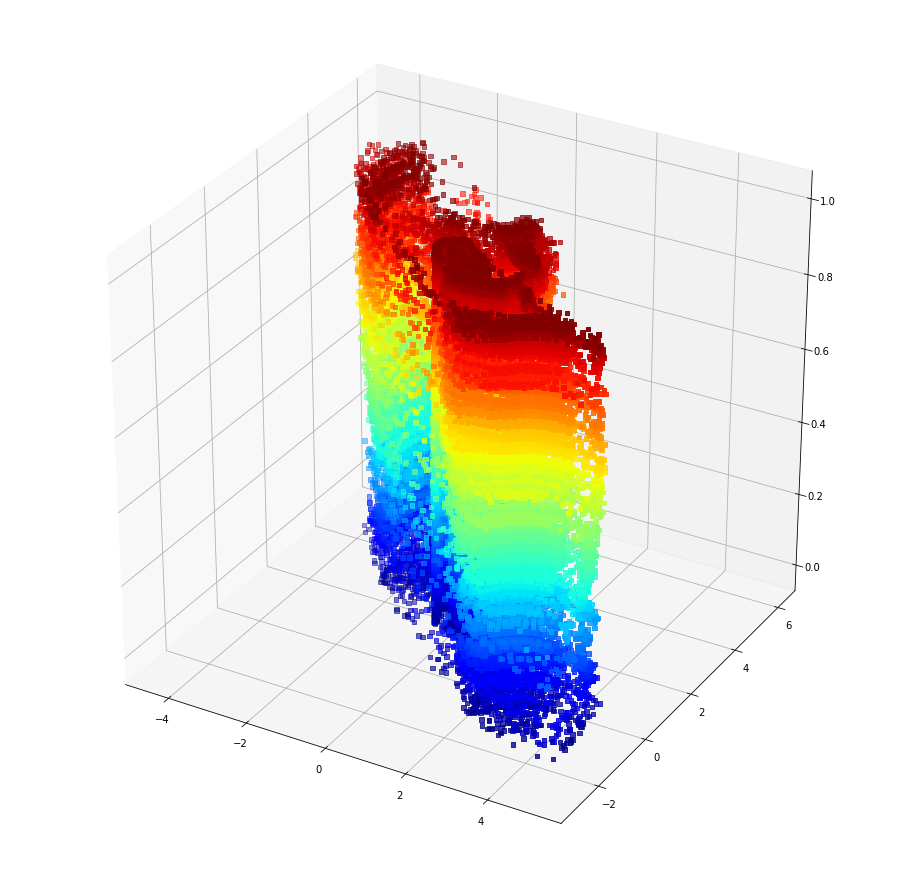

In [18]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], np.arange(len(ordered)) / len(ordered), c=np.arange(len(ordered)), cmap='jet', marker=',',)
plt.show()

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


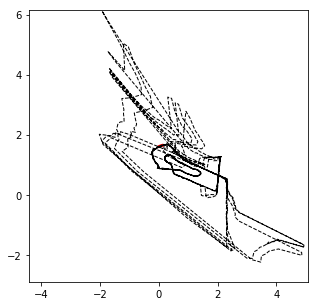

In [25]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(xlim=(x_test_encoded[0][:, 0].min(), x_test_encoded[0][:, 0].max()), ylim=(x_test_encoded[0][:, 1].min(), x_test_encoded[0][:, 1].max()))
line1, = ax.plot([], [], lw=3, c='r')
line2, = ax.plot([], [], lw=1, c='k', linestyle='--')

def init():
    line1.set_data([], [])
    line2.set_data([], [])    
    return line1, line2


def animate(i):
    y = np.array(x_test_encoded[0][i: i + 3])
    y2 = x_test_encoded[0][:i]
    line1.set_data(y[:, 0], y[:, 1])
    line2.set_data(y2[:, 0], y2[:, 1])
    return line1, line2

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, blit=True)
anim.save('test.gif')

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(x_test_encoded[0][:1000, 1], c='r')
plt.plot(x_test_encoded[0][:1000, 0], c='g')

In [ ]:
for i in range(10):
    plt.figure(figsize=(10, 8))
    recon = vae.predict(ordered[i: i+1])
    plt.plot(recon[0], c='r', label='Reconstruction')
    plt.plot(ordered[i], c='k', linestyle='--', label='Actual')
    plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
low, hi = 0, .5
for m in np.linspace(low, hi, 50):
    inp = np.zeros((1, latent_dim))
    c = (m - low) / (hi - low)
    lw = (1-c) * 1 + 1
    c = (c, .2, .5)
    inp[0, 0] = m
    
    recon = decoder.predict(inp)
    plt.plot(recon[0], label=f'{m:.2f}', c=c, linewidth=lw)

In [ ]:
plt.figure(figsize=(15, 8))

low, hi = 0, 1
raw = ordered[100000: 100000+1]

inp = encoder.predict(raw)[0]

r = decoder.predict(inp)
for m in np.linspace(low, hi, 50):
    c = (m - low) / (hi - low)
    lw = (1-c) * 1 + 1
    c = (c, .2, .5)
    inp = encoder.predict(raw)[0]
    inp[0, 0] += m 
    recon = decoder.predict(inp)
    plt.plot(recon[0] - r[0], label=f'{m:.2f}', c=c, linewidth=lw)
plt.plot(r[0], c='k', linestyle='--')